<a href="https://www.kaggle.com/code/andrejzuba/titanic-competition-solution-quick-0-8-result?scriptVersionId=109840590" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#importing custom library
!pip install git+https://github.com/Vrboska/mofr@master

  Cloning https://github.com/Vrboska/mofr (to revision master) to /tmp/pip-req-build-nf79xf5z
  Running command git clone --filter=blob:none --quiet https://github.com/Vrboska/mofr /tmp/pip-req-build-nf79xf5z
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Vrboska/mofr to commit 7c9071ad589532d8102cff3cd162607f1e1257a3
  Preparing metadata (setup.py) ... - done
  Created wheel for mofr: filename=mofr-1.0-py3-none-any.whl size=26368 sha256=9d213636ff076c3fbeebaebdfe77ad59dda9a052df92c1849792a1c922f525b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-nx6ogcvs/wheels/b8/d0/2a/36bf0097c9fa72bb9af2b201e9b71bbfa6ebbae4fc8d066dc7
Successfully built mofr


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             f1_score, precision_score,
                             recall_score, roc_auc_score)
from xgboost import XGBClassifier, plot_tree

import xgboost as xgb

In [4]:
seed=1234

In [5]:
train=pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Exploration

In [9]:
train.info()
print('--------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [12]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [13]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


# Predictor checking

In [14]:
train['Survived'].value_counts(dropna=False, normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [17]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
from mofr.basic_evaluators.HistogramContinuous import HistogramContinuousEvaluator

hcoe=HistogramContinuousEvaluator()

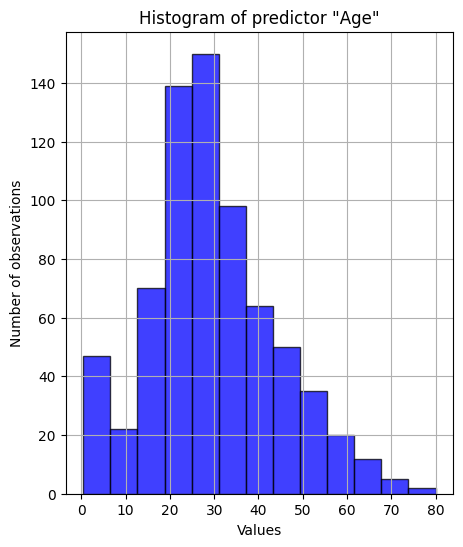

,Age
percentile_10,14.000000
percentile_25,20.125000
percentile_50,28.000000
percentile_75,38.000000
percentile_90,50.000000


In [19]:
hcoe.d(train[train['Age'].fillna(-1)!=-1]).pc('Age')
hcoe.get_graph()
hcoe.get_table()
hcoe.table


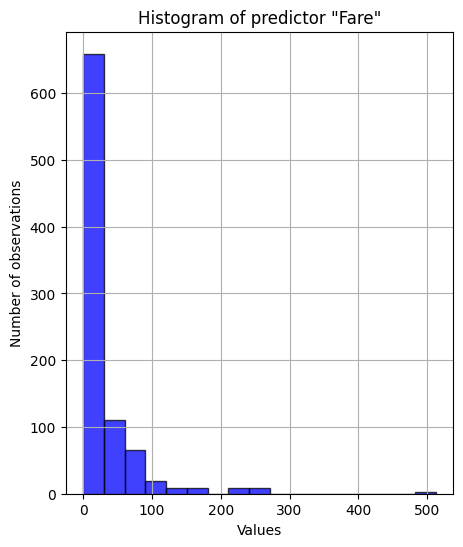

In [20]:
hcoe.d(train[train['Fare'].fillna(-1)!=-1]).pc('Fare')
hcoe.get_graph()

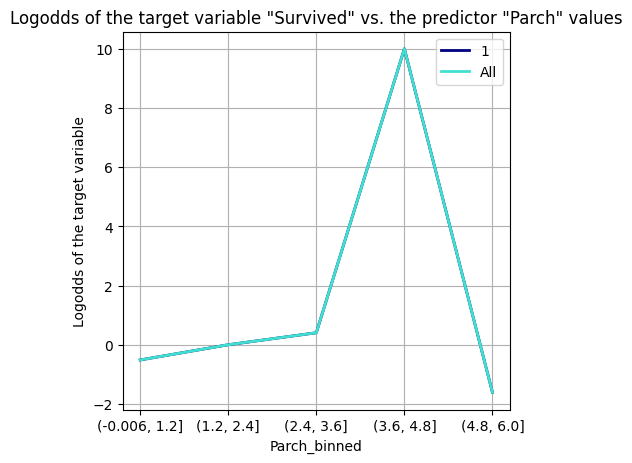

In [21]:
from mofr.basic_evaluators.TargetAssociationContinuous import TargetAssociationContinuousEvaluator

train['one']=1
tacoe=TargetAssociationContinuousEvaluator()
tacoe.d(train.fillna(-1)).t([('Survived', 'one')]).pc('Parch').tc('one')
tacoe.get_graph()

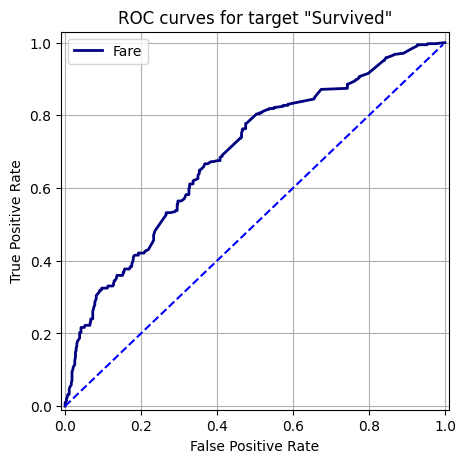

In [22]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator

rce=ROCCurveEvaluator()
rce.d(train.fillna(-1)).t([('Survived', 'one')]).s(['Fare'])
rce.get_graph()

# Data transformations

In [23]:
#extracting title from name
def name_trans(x):
    if 'Mr.' in x:
        return 'Mr.'
    elif 'Mrs.' in x:
        return 'Mrs.'
    elif 'Miss.' in x:
        return 'Miss.'
    elif 'Master.' in x:
        return 'Master.'
    else:
        return 'Other'

In [24]:
train['Name'].apply(name_trans).value_counts()

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Other       27
Name: Name, dtype: int64

In [25]:
train['Title']=train['Name'].apply(name_trans)
test['Title']=test['Name'].apply(name_trans)

In [26]:
train['Male_flag']=[1.0 if x=='male' else 0.0 for x in train['Sex']]
test['Male_flag']=[1.0 if x=='male' else 0.0 for x in test['Sex']]

In [27]:
# Ticket count and Cabin count predictors, essentially how many more people were on same ticket or same cabin
train=train.merge(pd.DataFrame(train.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')
train=train.merge(pd.DataFrame(train.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')
test=test.merge(pd.DataFrame(test.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')
train=train.merge(pd.DataFrame(train.groupby('Cabin')['Sex'].count().reset_index()).rename(columns={"Sex":'Cabin_count'}), how='left')
test=test.merge(pd.DataFrame(test.groupby('Cabin')['Sex'].count().reset_index()).rename(columns={"Sex":'Cabin_count'}), how='left')

In [28]:
#Age Fare combined predictor
train['Age_Fare']=train['Age']*train['Fare']
test['Age_Fare']=test['Age']*test['Fare']

In [29]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'one', 'Title',
       'Male_flag', 'Ticket_count', 'Cabin_count', 'Age_Fare'],
      dtype='object')

## Categorical transformations

In [30]:
import category_encoders as ce

In [31]:
cat_preds = ['Title', 'Embarked']

In [32]:
# bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(train[cat_preds], train['Survived'])

train = pd.concat([train, encoder.transform(train[cat_preds]).add_prefix("BAYES_")], axis=1)
test = pd.concat([test, encoder.transform(test[cat_preds]).add_prefix("BAYES_")], axis=1)

# Fitting models

In [33]:
train['one']=1
test['one']=1

In [34]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'one', 'Title',
       'Male_flag', 'Ticket_count', 'Cabin_count', 'Age_Fare', 'BAYES_Title',
       'BAYES_Embarked'],
      dtype='object')

In [35]:
col_preds=[
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Ticket_count',
 'Cabin_count',
 'Male_flag',
 'BAYES_Title',
 'BAYES_Embarked',
 'Age_Fare'    
]

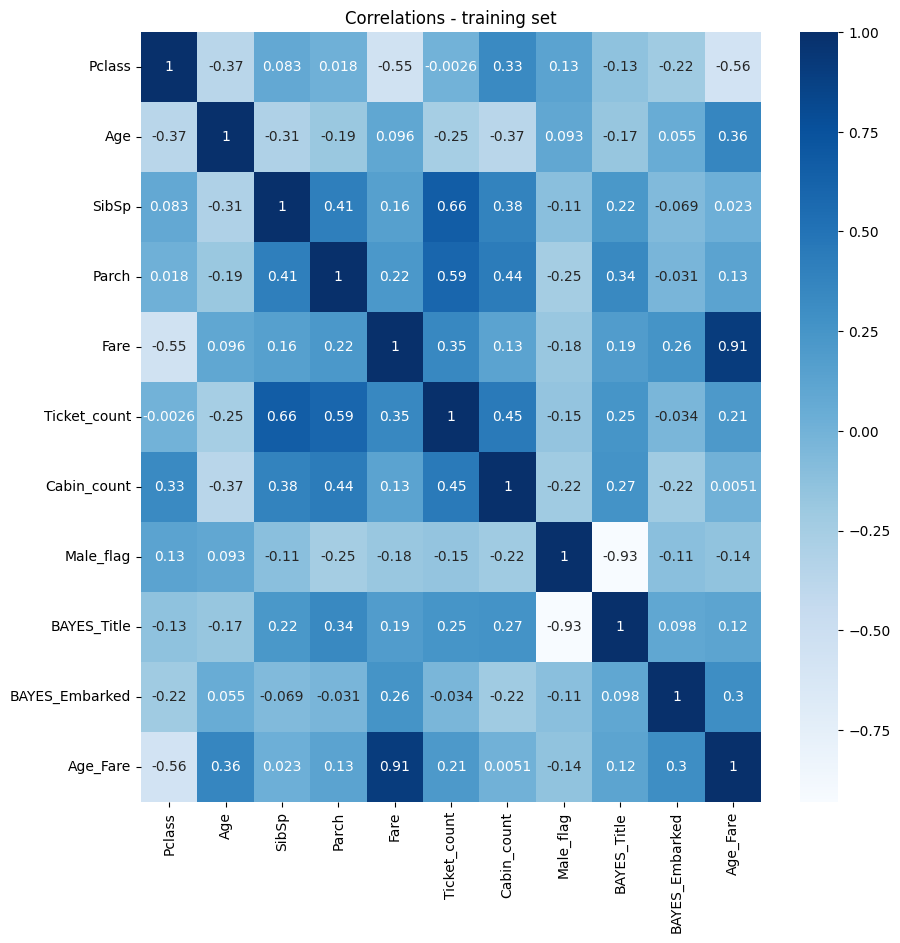

In [36]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
fig = sns.heatmap(train[col_preds].corr(), cbar=True, annot=True, cmap="Blues", ax=ax)
ax.set_title("Correlations - training set")
plt.show()

In [37]:
results=[]
for col in col_preds:
    results.append((col, np.abs(mofr.metrics.gini(train['Survived'], train[col].fillna(-999)))))

pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)

,Predictor,GINI
8,BAYES_Title,0.592912
7,Male_flag,0.533746
4,Fare,0.384245
0,Pclass,0.362834
6,Cabin_count,0.283082
10,Age_Fare,0.230387
5,Ticket_count,0.187646
9,BAYES_Embarked,0.155871
3,Parch,0.122434
2,SibSp,0.086324


## xgb_model

In [38]:
# approach taen is cross-validation across many different random samples->then averaging 
#the scores into final score at the end this did not bring much success
whole_lifts=[]
whole_ginis=[]

train_lifts=[]
train_ginis=[]

valid_lifts=[]
valid_ginis=[]

n=1
X_train, X_valid, y_train, y_valid= train_test_split(train[0:700], train['Survived'][0:700], test_size=0.2, random_state=seed)
train['FINAL_SCORE_AVG']=0
X_train['FINAL_SCORE_AVG']=0
X_valid['FINAL_SCORE_AVG']=0
test['FINAL_SCORE_AVG']=0

#train = train.sample(frac=1).reset_index(drop=True)
#test = test.sample(frac=1).reset_index(drop=True)


for random_seed in range(25):
    X_train, X_valid, y_train, y_valid= train_test_split(train[0:700], train['Survived'][0:700], test_size=0.2, random_state=random_seed)

    xgb_model = XGBClassifier(max_depth=3, seed=random_seed, colsample_bytree=1, gamma=1, min_child_weight=5, n_estimators=20)
    xgb_model.fit(X_train.loc[:, col_preds], X_train['Survived'])
    

    train['FINAL_SCORE'] =xgb_model.predict_proba(train[col_preds])[:, 1]
    X_train['FINAL_SCORE'] =xgb_model.predict_proba(X_train[col_preds])[:, 1]
    X_valid['FINAL_SCORE'] = xgb_model.predict_proba(X_valid[col_preds])[:, 1]
    test['FINAL_SCORE'] =xgb_model.predict_proba(test[col_preds])[:, 1]

        
    train['FINAL_SCORE_AVG'] =(train['FINAL_SCORE_AVG']*n+ xgb_model.predict_proba(train[col_preds])[:, 1])/(n+1)
    X_train['FINAL_SCORE_AVG'] =(X_train['FINAL_SCORE_AVG']*n+xgb_model.predict_proba(X_train[col_preds])[:, 1])/(n+1)
    X_valid['FINAL_SCORE_AVG'] = (X_valid['FINAL_SCORE_AVG']*n+xgb_model.predict_proba(X_valid[col_preds])[:, 1])/(n+1)
    test['FINAL_SCORE_AVG'] = (test['FINAL_SCORE_AVG']*n+xgb_model.predict_proba(test[col_preds])[:, 1])/(n+1)  
    n+=1 
    
    whole_lifts.append(mofr.metrics.lift(train['Survived'], train['FINAL_SCORE']))
    whole_ginis.append(mofr.metrics.gini(train['Survived'], train['FINAL_SCORE']))

    train_lifts.append(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE']))
    train_ginis.append(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE']))
    
    valid_lifts.append(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE']))
    valid_ginis.append(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE']));

In [39]:
np.std(valid_ginis)

0.06716879670735311

In [40]:
# print('The Lift on the whole set is: '+ str(np.mean(whole_lifts)))
# print('The gini on the whole set is: '+ str(np.mean(whole_ginis)))
# print('\n')
print('The Lift on the train set is: '+ str(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE_AVG'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE_AVG'])))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE_AVG'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE_AVG'])))
print('\n')
print('The Lift on the oot set is: '+ str(mofr.metrics.lift(train['Survived'][700:-1], train['FINAL_SCORE_AVG'][700:-1])))
print('The gini on the oot set is: '+ str(mofr.metrics.gini(train['Survived'][700:-1], train['FINAL_SCORE_AVG'][700:-1])))

The Lift on the train set is: 2.5
The gini on the train set is: 0.8319648171768708


The Lift on the valid set is: 2.9787234042553195
The gini on the valid set is: 0.8478609013955618


The Lift on the oot set is: 2.676056338028169
The gini on the oot set is: 0.8370221327967806


In [41]:
test['Survived']=test['FINAL_SCORE_AVG'].apply(lambda x: int(x>0.5))
test['Survived'].value_counts(normalize=True)

0    0.667464
1    0.332536
Name: Survived, dtype: float64

In [42]:
test[['PassengerId', 'Survived']].to_csv('Prediction_xgb_avg.csv', index=False)

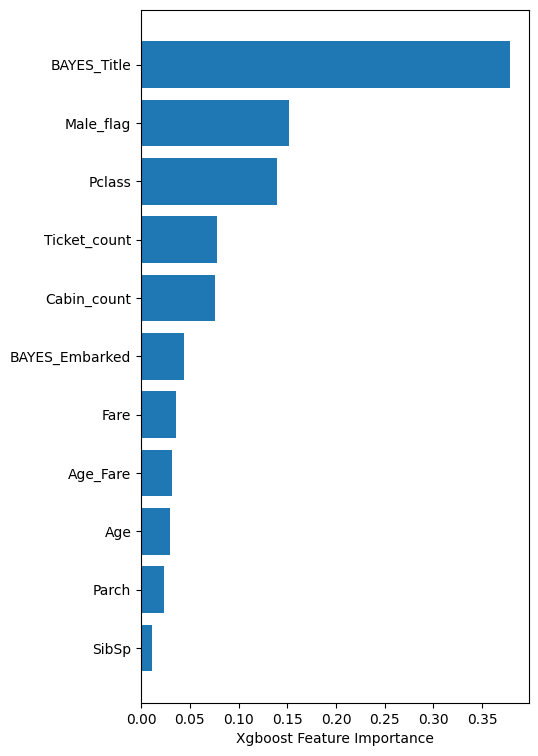

In [43]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(col_preds[i])
plt.figure(figsize=(5, 9))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

## Logistic regression model

In [44]:
col_preds

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Ticket_count',
 'Cabin_count',
 'Male_flag',
 'BAYES_Title',
 'BAYES_Embarked',
 'Age_Fare']

In [45]:
import statsmodels.api as sm

lr_cols=col_preds+['one']

#imputing just average values here
for col in lr_cols:
    train[col]=train[col].fillna(np.mean(train[col]))
    test[col]=test[col].fillna(np.mean(train[col]))

In [46]:
# similar approach taken as for XGBoost, but not averaging the scores at the end
whole_lifts=[]
whole_ginis=[]

train_lifts=[]
train_ginis=[]

valid_lifts=[]
valid_ginis=[]

for random_seed in range(100):
    X_train, X_valid, y_train, y_valid= train_test_split(train, train['Survived'], test_size=0.2, random_state=random_seed)

    X=X_train[lr_cols]
    y=y_train

    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    
    train['FINAL_SCORE'] = result.predict(train[lr_cols])
    X_train['FINAL_SCORE'] = result.predict(X_train[lr_cols])
    X_valid['FINAL_SCORE'] = result.predict(X_valid[lr_cols])
    
    whole_lifts.append(mofr.metrics.lift(train['Survived'], train['FINAL_SCORE']))
    whole_ginis.append(mofr.metrics.gini(train['Survived'], train['FINAL_SCORE']))

    train_lifts.append(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE']))
    train_ginis.append(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE']))
    
    valid_lifts.append(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE']))
    valid_ginis.append(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE']))

Optimization terminated successfully.
         Current function value: 0.414953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398219
  

In [47]:
np.std(valid_ginis)

0.06053526105353131

In [48]:
# print('The Lift on the whole set is: '+ str(np.mean(whole_lifts)))
# print('The gini on the whole set is: '+ str(np.mean(whole_ginis)))
# print('\n')
print('The Lift on the train set is: '+ str(np.mean(train_lifts)))
print('The gini on the train set is: '+ str(np.mean(train_ginis)))
print('\n')
print('The Lift on the valid set is: '+ str(np.mean(valid_lifts)))
print('The gini on the valid set is: '+ str(np.mean(valid_ginis)))

The Lift on the train set is: 2.5319550090478566
The gini on the train set is: 0.7439138187996813


The Lift on the valid set is: 2.515878871206539
The gini on the valid set is: 0.7329595403840485


In [49]:
test['FINAL_SCORE'] = result.predict(test[lr_cols])

In [50]:
threshold=0.6577 #found after some expermenting and submitting a few times

In [51]:
(test['FINAL_SCORE']>threshold).value_counts(normalize=True)

False    0.662679
True     0.337321
Name: FINAL_SCORE, dtype: float64

In [52]:
test['Survived']=(test['FINAL_SCORE']>threshold).apply(int)

In [53]:
test[['PassengerId', 'Survived']].to_csv('Prediction_lr.csv', index=False)